In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D

#
import plotly.graph_objects as go
import plotly.express as px

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('DXG Historical Data.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/02/2023,"15,150.0","15,400.0","15,500.0","15,000.0",20.98M,0.00%
1,06/01/2023,"15,150.0","14,900.0","15,200.0","14,850.0",18.46M,1.68%
2,05/31/2023,"14,900.0","14,950.0","15,200.0","14,850.0",15.10M,-0.33%
3,05/30/2023,"14,950.0","14,950.0","15,200.0","14,750.0",30.20M,2.40%
4,05/29/2023,"14,600.0","14,650.0","14,750.0","14,500.0",13.24M,1.04%
...,...,...,...,...,...,...,...
1366,12/07/2017,"12,100.6","12,161.1","12,312.3","11,858.5",5.23M,-0.50%
1367,12/06/2017,"12,161.1","12,161.1","12,342.6","11,919.0",7.72M,-0.99%
1368,12/05/2017,"12,282.1","12,705.6","12,917.3","12,282.1",11.06M,-3.33%
1369,12/04/2017,"12,705.6","12,463.6","12,705.6","12,282.1",9.42M,3.70%


In [3]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [4]:
tranformData(df)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-06-02,15150.0,15400.0,15500.0,15000.0,20980000.0,0.0000
1,2023-06-01,15150.0,14900.0,15200.0,14850.0,18460000.0,0.0168
2,2023-05-31,14900.0,14950.0,15200.0,14850.0,15100000.0,-0.0033
3,2023-05-30,14950.0,14950.0,15200.0,14750.0,30200000.0,0.0240
4,2023-05-29,14600.0,14650.0,14750.0,14500.0,13240000.0,0.0104
...,...,...,...,...,...,...,...
1366,2017-12-07,12100.6,12161.1,12312.3,11858.5,5230000.0,-0.0050
1367,2017-12-06,12161.1,12161.1,12342.6,11919.0,7720000.0,-0.0099
1368,2017-12-05,12282.1,12705.6,12917.3,12282.1,11060000.0,-0.0333
1369,2017-12-04,12705.6,12463.6,12705.6,12282.1,9420000.0,0.0370


In [5]:
df=df.sort_values(['Date'])
df1=df.reset_index()['Price']
df

,Date,Price,Open,High,Low,Vol.,Change %
1370,2017-12-01,12251.8,11949.3,12403.1,11919.0,8610000.0,0.0279
1369,2017-12-04,12705.6,12463.6,12705.6,12282.1,9420000.0,0.0370
1368,2017-12-05,12282.1,12705.6,12917.3,12282.1,11060000.0,-0.0333
1367,2017-12-06,12161.1,12161.1,12342.6,11919.0,7720000.0,-0.0099
1366,2017-12-07,12100.6,12161.1,12312.3,11858.5,5230000.0,-0.0050
...,...,...,...,...,...,...,...
4,2023-05-29,14600.0,14650.0,14750.0,14500.0,13240000.0,0.0104
3,2023-05-30,14950.0,14950.0,15200.0,14750.0,30200000.0,0.0240
2,2023-05-31,14900.0,14950.0,15200.0,14850.0,15100000.0,-0.0033
1,2023-06-01,15150.0,14900.0,15200.0,14850.0,18460000.0,0.0168


In [6]:
df.describe()


,Price,Open,High,Low,Vol.,Change %
count,1371.000000,1371.000000,1371.000000,1371.000000,1.371000e+03,1371.000000
mean,17674.362509,17660.057695,18070.651058,17290.551860,7.081185e+06,0.000702
std,7590.149172,7578.982544,7806.761118,7367.071153,5.709696e+06,0.032425
min,6739.100000,6269.600000,6947.800000,6269.600000,4.483700e+05,-0.070000
25%,12395.650000,12434.800000,12608.700000,12220.800000,2.750000e+06,-0.016300
50%,16066.500000,16100.000000,16350.000000,15793.000000,5.640000e+06,0.000000
75%,20852.300000,20800.000000,21217.200000,20435.000000,9.835000e+06,0.019600
max,46750.000000,46500.000000,47450.000000,46200.000000,4.930000e+07,0.070000


In [7]:
fig = px.line(df, x=df.Date, y=df.Price,labels={'Date':'Date','Price':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price for chart of DXG', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [8]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [10]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [11]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [12]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [13]:
# 8.
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a LSTM layer
model.add(LSTM(100, activation='relu'))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [14]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 16s 129ms/step - loss: 0.0205 - val_loss: 0.0187
Epoch 2/100
14/14 [==============================] - 1s 88ms/step - loss: 0.0036 - val_loss: 0.0173
Epoch 3/100
14/14 [==============================] - 1s 95ms/step - loss: 0.0018 - val_loss: 0.0090
Epoch 4/100
14/14 [==============================] - 1s 94ms/step - loss: 9.9394e-04 - val_loss: 0.0189
Epoch 5/100
14/14 [==============================] - 1s 88ms/step - loss: 8.7450e-04 - val_loss: 0.0183
Epoch 6/100
14/14 [==============================] - 1s 87ms/step - loss: 8.1509e-04 - val_loss: 0.0134
Epoch 7/100
14/14 [==============================] - 2s 151ms/step - loss: 7.8119e-04 - val_loss: 0.0111
Epoch 8/100
14/14 [==============================] - 2s 122ms/step - loss: 7.6214e-04 - val_loss: 0.0092
Epoch 9/100
14/14 [==============================] - 1s 91ms/step - loss: 7.2662e-04 - val_loss: 0.0068
Epoch 10/100
14/14 [==============================] - 1s 85ms/step - los

In [15]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 74ms/step


In [16]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [17]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 13814.993187265469
Testing RMSE: 26172.61399309346


In [18]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.21231943]
101
1 day input [0.16647713 0.1614785  0.15023156 0.14523292 0.16522748 0.15772952
 0.15398054 0.15273088 0.17147577 0.18522203 0.18147305 0.18397237
 0.19147032 0.20396692 0.17897373 0.16772679 0.16647713 0.16897645
 0.1489819  0.14398326 0.13898463 0.12148939 0.10149484 0.08774859
 0.10524382 0.11024246 0.11024246 0.12898735 0.12648803 0.10649348
 0.10399416 0.09024791 0.07675159 0.08150029 0.08899825 0.08524927
 0.08399961 0.10149484 0.09399689 0.11149212 0.11149212 0.11274178
 0.11149212 0.09774586 0.1152411  0.11774042 0.12398871 0.1089928
 0.12023973 0.11899008 0.12523837 0.12773769 0.13523565 0.14023429
 0.14148395 0.14273361 0.14523292 0.16647713 0.16647713 0.17397509
 0.15897918 0.17147577 0.16522748 0.17397509 0.17272543 0.17397509
 0.15023156 0.1489819  0.15772952 0.1489819  0.14648258 0.14773224
 0.15023156 0.14523292 0.14648258 0.1614785  0.16897645 0.16397782
 0.1614785  0.16522748 0.16647713 0.18897101 0.19396964 0.19771862
 0.18522203 0.19396964 0.18022339 

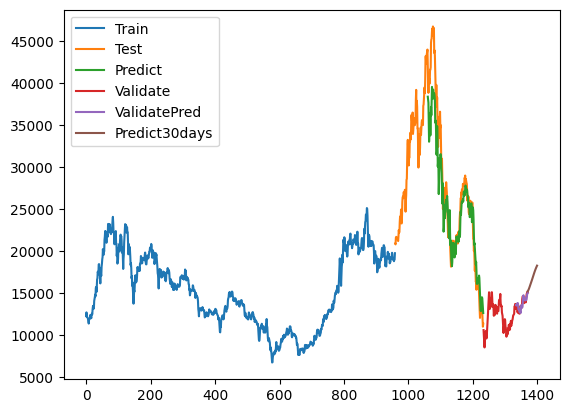

In [19]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()